In [15]:
from libs.data_manipulation import *
from libs.dim_reduction import *
from libs.feature_generation import *
from libs.clustering import *

In [16]:
df = compile_team_tracking_data("data", "Denmark")
df = extract_one_match(df,1)


In [17]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d

In [18]:
def convex_hull(df : pd.DataFrame, regex : str):
    df = df.filter(regex=regex)
    np_data = df.to_numpy()
    points = []
    for row in np_data:
        row = row[~np.isnan(row)]
        points.append(list(zip(row[0::2],row[1::2])))
    hulls = []
    i=0
    for data in points:
        i=i+1

        hulls.append(ConvexHull(data))
    return hulls



In [22]:

hulls = convex_hull(df.iloc[::48], "^home")



1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


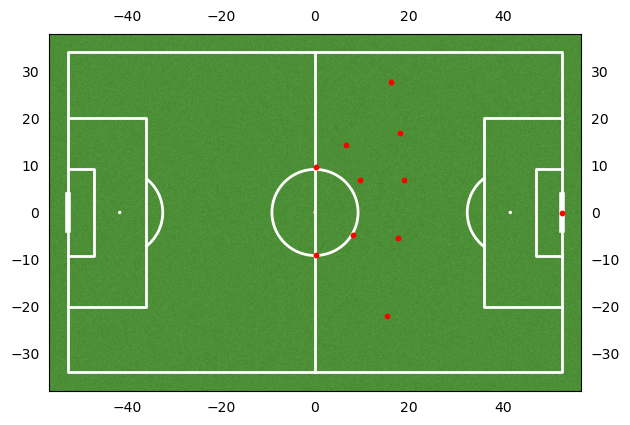

In [39]:

from mplsoccer import Pitch

import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

def hull_to_polygon(hull):
    """Convert a scipy ConvexHull object to a shapely Polygon."""
    points = hull.points[hull.vertices]
    return Polygon(points)

def find_centroid(hull):
    """Find the centroid of a ConvexHull."""
    points = hull.points[hull.vertices]
    centroid = np.mean(points, axis=0)
    return centroid

def normalize_hull(hull):
    """Normalize a ConvexHull by centering it around (0, 0)."""
    centroid = find_centroid(hull)
    normalized_points = hull.points - centroid  # Translate points to center around (0, 0)
    return ConvexHull(normalized_points)

def overlapping_area(hull1, hull2):
    """Compute the overlapping area between two convex hulls."""
    poly1 = hull_to_polygon(hull1)
    poly2 = hull_to_polygon(hull2)
    
    if not poly1.intersects(poly2):
        return 0.0
    
    intersection = poly1.intersection(poly2)
    return intersection.area

def top_n_similar_hulls(target_hull, hull_list, n=10):
    """Find the top n hulls with the largest overlapping area with the target hull."""
    # Normalize the target hull
    target_hull_normalized = normalize_hull(target_hull)
    
    # Calculate the overlapping area for each normalized hull in the list
    areas = [(hull, overlapping_area(target_hull_normalized, normalize_hull(hull))) for hull in hull_list]
    
    # Sort the hulls by the overlapping area in descending order
    areas_sorted = sorted(areas, key=lambda x: x[1], reverse=True)
    
    # Return the top n hulls
    return areas_sorted[:n]

# Example usage




top_10_hulls = top_n_similar_hulls(hulls[100], hulls)

football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
football_pitch.draw()  # Draw the pitch on the current axis

plt.scatter(hulls[100].points[:, 0], hulls[100].points[:, 1], color='red', s=10)
plt.show()


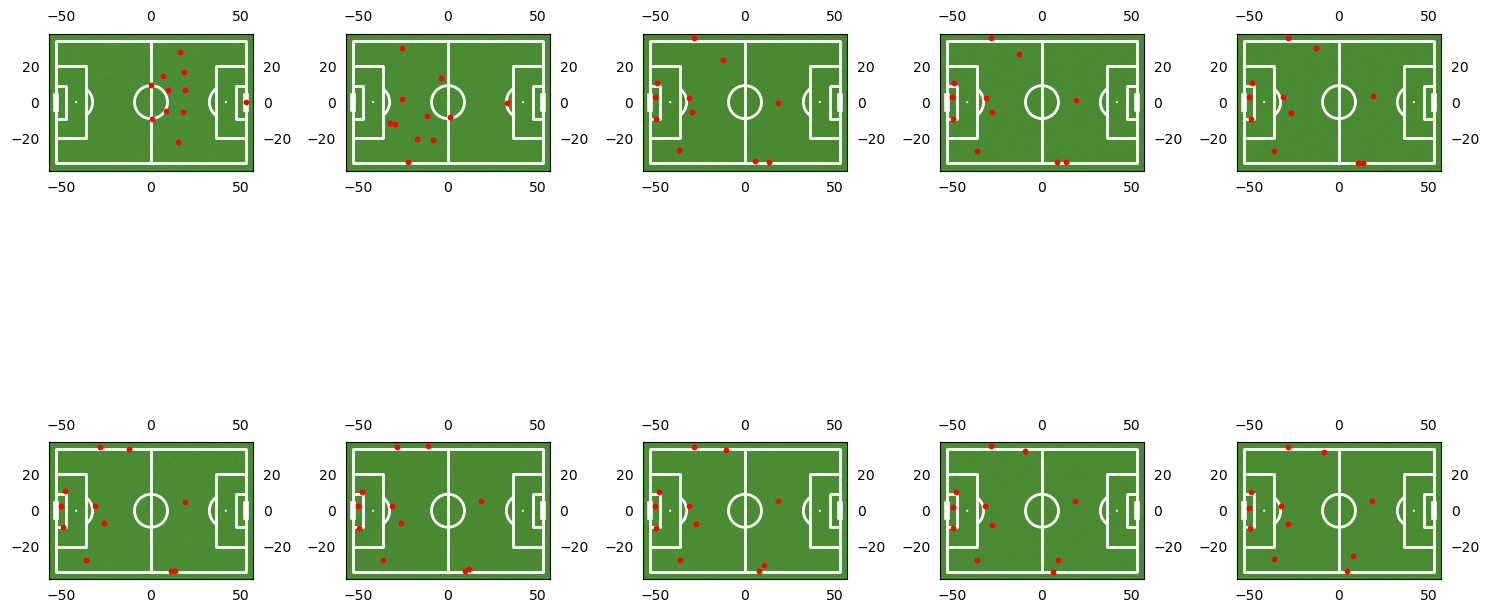

In [36]:

fig, ax = plt.subplots(2, 5, figsize=(15, 10))

# Create the pitch with the desired settings
for hull, i in zip(top_10_hulls, range(len(top_10_hulls))):
    row = i // 5  # Determine the row index
    col = i % 5   # Determine the column index
    
    # Create a new pitch on each subplot
    football_pitch = Pitch(pitch_type='skillcorner', pitch_length=105, pitch_width=68, axis=True, 
                           label=True, line_color="white", pitch_color="grass")
    football_pitch.draw(ax=ax[row, col])  # Draw the pitch on the current axis
    
    # Scatter plot for convex hull points
    ax[row, col].scatter(hull[0].points[:, 0], hull[0].points[:, 1], color='red', s=10)

plt.tight_layout()
plt.show()

